# Introduction

Project overview


# Section 1: Loading and Cleaning

This code block contains the imports for packages that we need to complete our report.

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F



Data loading via Google Drive

In [2]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
cd /content/drive/Shareddrives/CIS5450/archive

/content/drive/Shareddrives/CIS5450/archive


Loading in the files from Google Drive

In [4]:
acquisitions_df = pd.read_csv("acquisitions.csv")
degrees_df = pd.read_csv("degrees.csv")
funding_rounds_df = pd.read_csv("funding_rounds.csv")
funds_df = pd.read_csv("funds.csv")
investments_df = pd.read_csv("investments.csv")
milestones_df = pd.read_csv("milestones.csv")
objects_df = pd.read_csv("objects.csv")
offices_df = pd.read_csv("offices.csv")
ipos_df = pd.read_csv("ipos.csv")
people_df = pd.read_csv("people.csv")
relationships_df = pd.read_csv("relationships.csv")
inflation_df = pd.read_csv("inflation.csv")

<ipython-input-4-4b4b469c25b9>:7: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv("objects.csv")


# **Cleaning `objects.df` to Reflect Startups**

`objects.df` is our main data set. It contains start up companies, some of the people, and some of the products. Given the large assortment of entities, we have some cleaning to do.

In [5]:
objects_df

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462646,r:9995,Product,9995,c:14164,"SiteLink, listing feed for Brokerages",sitelink listing feed for brokerages,/product/sitelink-listing-feed-for-brokerages,NaN,operating,NaN,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-11-28 14:34:12,2008-11-28 23:24:22
462647,r:9996,Product,9996,c:14164,"EDCLink, listing feed for Economic Development...",edclink listing feed for economic development ...,/product/edclink-listing-feed-for-economic-dev...,NaN,operating,NaN,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-11-28 14:34:13,2008-11-28 23:24:23
462648,r:9997,Product,9997,c:14164,"Cmail, broadcast email marketing",cmail broadcast email marketing,/product/cmail-broadcast-email-marketing,NaN,operating,NaN,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-11-28 14:34:13,2008-11-28 23:24:23
462649,r:9998,Product,9998,c:14164,"CatylistCRM, contact database",catylistcrm contact database,/product/catylistcrm-contact-database,NaN,operating,NaN,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-11-28 14:34:13,2008-11-28 23:24:23


In [6]:
objects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462651 entries, 0 to 462650
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   462651 non-null  object 
 1   entity_type          462651 non-null  object 
 2   entity_id            462651 non-null  int64  
 3   parent_id            27715 non-null   object 
 4   name                 462647 non-null  object 
 5   normalized_name      462620 non-null  object 
 6   permalink            462651 non-null  object 
 7   category_code        123186 non-null  object 
 8   status               462651 non-null  object 
 9   founded_at           100441 non-null  object 
 10  closed_at            2809 non-null    object 
 11  domain               174942 non-null  object 
 12  homepage_url         174942 non-null  object 
 13  twitter_username     126089 non-null  object 
 14  logo_url             208850 non-null  object 
 15  logo_width       

In [7]:
objects_df['entity_type'].value_counts()

entity_type
Person          226708
Company         196553
Product          27738
FinancialOrg     11652
Name: count, dtype: int64

We can first filter out all the non-companies, as our investigation mainly wants to focus on start-up success.

In [8]:
startup_df = objects_df[objects_df['entity_type'] == 'Company']

In [9]:
startup_df

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196548,c:99940,Company,99940,NaN,Webgility,webgility,/company/webgility,ecommerce,operating,2007-01-01,...,NaN,0,0.0,2013-08-12,2013-08-12,2,5,NaN,2011-09-06 23:17:56,2013-08-13 00:39:13
196549,c:9995,Company,9995,NaN,FohBoh,fohboh,/company/fohboh,public_relations,operating,2007-11-01,...,2008-08-25,1,750000.0,2013-05-01,2013-05-01,1,14,NaN,2008-08-24 15:46:26,2013-06-28 20:55:30
196550,c:9996,Company,9996,NaN,CSC,csc,/company/csc,consulting,operating,1959-01-01,...,NaN,0,0.0,2012-01-01,2013-10-30,3,44,NaN,2008-08-24 15:46:58,2013-06-28 20:52:01
196551,c:9997,Company,9997,NaN,Top-candidate,top candidate,/company/top-candidate,search,operating,2008-07-01,...,NaN,0,0.0,NaN,NaN,0,1,NaN,2008-08-24 16:00:22,2013-06-28 20:56:44


In [10]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196553 entries, 0 to 196552
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   196553 non-null  object 
 1   entity_type          196553 non-null  object 
 2   entity_id            196553 non-null  int64  
 3   parent_id            0 non-null       object 
 4   name                 196552 non-null  object 
 5   normalized_name      196549 non-null  object 
 6   permalink            196553 non-null  object 
 7   category_code        123186 non-null  object 
 8   status               196553 non-null  object 
 9   founded_at           91227 non-null   object 
 10  closed_at            2620 non-null    object 
 11  domain               126545 non-null  object 
 12  homepage_url         126545 non-null  object 
 13  twitter_username     80591 non-null   object 
 14  logo_url             110110 non-null  object 
 15  logo_width           1

In [11]:
startup_df.nunique()

id                     196553
entity_type                 1
entity_id              196553
parent_id                   0
name                   196505
normalized_name        195685
permalink              196512
category_code              42
status                      4
founded_at               6156
closed_at                 925
domain                 125498
homepage_url           125961
twitter_username        79571
logo_url               110110
logo_width               3326
logo_height              2129
short_description        7128
description             83741
overview               126876
tag_list                79133
country_code              175
state_code                 51
city                    10727
region                   5865
first_investment_at      1197
last_investment_at       1105
investment_rounds          42
invested_companies         38
first_funding_at         3208
last_funding_at          2978
funding_rounds             16
funding_total_usd        9721
first_mile

We have quite a lot of columns, a good amount of which we probably don't want to concern ourselves with. We don't need much about location except which country it is in (and possibly the state), since we don't want too many categories to work with. We also don't care much about the company specifics like their logo or their pitch. However, we keep their tag list and category for future investigation. We also keep funding and relationships to merge on later.

In [12]:
startup_df = startup_df.copy()
keep_cols = ['id', 'name', 'category_code', 'status', 'founded_at', 'tag_list', 'country_code', 'state_code',
             'funding_rounds', 'funding_total_usd', 'relationships']

startup_df = startup_df[keep_cols]
startup_df['state_code'] = startup_df['state_code'].fillna('')
startup_df['country_code'] = startup_df['country_code'].fillna('')
startup_df['tag_list'] = startup_df['tag_list'].fillna('')
startup_df['category_code'] = startup_df['category_code'].fillna('other')
startup_df

,id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17
1,c:10,Flektor,games_video,acquired,NaN,"flektor, photo, video",USA,CA,0,0.0,6
2,c:100,There,games_video,acquired,NaN,"virtualworld, there, teens",USA,CA,0,0.0,12
3,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0
4,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
196548,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5
196549,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14
196550,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44
196551,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1


In [13]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196553 entries, 0 to 196552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 196553 non-null  object 
 1   name               196552 non-null  object 
 2   category_code      196553 non-null  object 
 3   status             196553 non-null  object 
 4   founded_at         91227 non-null   object 
 5   tag_list           196553 non-null  object 
 6   country_code       196553 non-null  object 
 7   state_code         196553 non-null  object 
 8   funding_rounds     196553 non-null  int64  
 9   funding_total_usd  196553 non-null  float64
 10  relationships      196553 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 18.0+ MB


We have a lot of companies that we do not know their founded date. Since we want to define success based on it (expanded on later), we will drop nulls.

In [14]:
startup_df = startup_df.rename(columns = {'id':'company_id'})

startup_df.dropna(inplace=True)
startup_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17
3,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0
4,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0
5,c:10002,Synergie Media,advertising,operating,2007-06-27,"social-media, web-design, web-development, out...",MAR,,0,0.0,2
6,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"cleantech, alternative-energy, biogas, carbon-...",IND,,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
196548,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5
196549,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14
196550,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44
196551,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1


In [15]:
startup_df['founded_at'] = pd.to_datetime(startup_df['founded_at'])
startup_df['founding_year'] = (startup_df['founded_at'].dt.year).astype(int)

In [16]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 196552
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         91226 non-null  object        
 1   name               91226 non-null  object        
 2   category_code      91226 non-null  object        
 3   status             91226 non-null  object        
 4   founded_at         91226 non-null  datetime64[ns]
 5   tag_list           91226 non-null  object        
 6   country_code       91226 non-null  object        
 7   state_code         91226 non-null  object        
 8   funding_rounds     91226 non-null  int64         
 9   funding_total_usd  91226 non-null  float64       
 10  relationships      91226 non-null  int64         
 11  founding_year      91226 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 11.1+ MB


# **Adding Funding Round Data from `funding_rounds_df`**

`funding_rounds_df` is one of the dataframes that we will merge with `startup_df`. This contains information about specific funding rounds and how much money was recieved by companies.

In [17]:
funding_rounds_df

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,...,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at,updated_at
0,1,1,c:4,2006-12-01,series-b,b,8500000.0,8500000.0,USD,0.0,...,0.0,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,2,c:5,2004-09-01,angel,angel,500000.0,500000.0,USD,0.0,...,0.0,USD,2,0,1,NaN,NaN,initial-importer,2007-05-27 06:08:18,2013-06-28 20:07:23
2,3,3,c:5,2005-05-01,series-a,a,12700000.0,12700000.0,USD,115000000.0,...,0.0,USD,3,0,0,http://www.techcrunch.com/2007/11/02/jim-breye...,Jim Breyer: Extra $500 Million Round For Faceb...,initial-importer,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,2006-04-01,series-b,b,27500000.0,27500000.0,USD,525000000.0,...,0.0,USD,4,0,0,http://www.facebook.com/press/info.php?factsheet,Facebook Funding,initial-importer,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,5,c:7299,2006-05-01,series-b,b,10500000.0,10500000.0,USD,0.0,...,0.0,NaN,2,0,0,http://www.techcrunch.com/2006/05/14/photobuck...,PhotoBucket Closes $10.5M From Trinity Ventures,initial-importer,2007-05-29 11:05:59,2008-04-16 17:09:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52923,57948,57948,c:211890,2013-12-12,series-a,a,3000000.0,3000000.0,USD,0.0,...,0.0,USD,1,1,1,http://techcrunch.com/2013/12/12/bitstrips-ser...,"Bitstrips Confirms $3M Series A From Horizons,...",amit2013,2013-12-12 14:12:05,2013-12-12 14:12:05
52924,57949,57949,c:267427,2010-02-06,venture,partial,570000.0,570000.0,USD,0.0,...,0.0,USD,0,0,1,http://www.sec.gov/Archives/edgar/data/1434188...,SEC,santosh2013,2013-12-12 14:13:11,2013-12-12 14:13:11
52925,57950,57950,c:261728,2010-02-06,venture,unattributed,2184100.0,2184100.0,USD,0.0,...,0.0,USD,0,0,1,http://www.sec.gov/Archives/edgar/data/1335158...,SEC,santosh2013,2013-12-12 14:19:35,2013-12-12 14:19:35
52926,57951,57951,c:285864,2013-12-12,series-a,a,790783.0,790783.0,USD,0.0,...,0.0,USD,0,1,1,http://www.startupticker.ch/en/news/december-2...,UrbanFarmers closes interim-investment round,amit2013,2013-12-12 14:23:49,2013-12-12 14:23:49


Here we change the date to the datetime datatype.

In [18]:
valid_funding_rounds_df = funding_rounds_df.dropna(subset=['funded_at'])

In [19]:
valid_funding_rounds_df = valid_funding_rounds_df.copy()
valid_funding_rounds_df['funded_at'] = pd.to_datetime(valid_funding_rounds_df['funded_at'])

In [20]:
valid_funding_rounds_df['year'] = (valid_funding_rounds_df['funded_at'].dt.year).astype(int)

In [21]:
valid_funding_rounds_df['funded_at'] = valid_funding_rounds_df['funded_at'].dt.date

In [22]:
columns_to_drop = [
    'id', 'funding_round_id', 'raised_amount',
    'raised_currency_code', 'pre_money_valuation_usd', 'pre_money_valuation',
    'pre_money_currency_code', 'post_money_valuation_usd', 'post_money_valuation',
    'post_money_currency_code', 'participants', 'source_url', 'source_description',
    'created_by', 'created_at', 'updated_at', 'is_first_round', 'is_last_round'
]

# Dropping the columns
valid_funding_rounds_df = valid_funding_rounds_df.drop(columns=columns_to_drop)
valid_funding_rounds_df

,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year
0,c:4,2006-12-01,series-b,b,8500000.0,2006
1,c:5,2004-09-01,angel,angel,500000.0,2004
2,c:5,2005-05-01,series-a,a,12700000.0,2005
3,c:5,2006-04-01,series-b,b,27500000.0,2006
4,c:7299,2006-05-01,series-b,b,10500000.0,2006
...,...,...,...,...,...,...
52923,c:211890,2013-12-12,series-a,a,3000000.0,2013
52924,c:267427,2010-02-06,venture,partial,570000.0,2010
52925,c:261728,2010-02-06,venture,unattributed,2184100.0,2010
52926,c:285864,2013-12-12,series-a,a,790783.0,2013


In [23]:
grouped_vfrs_df = valid_funding_rounds_df.groupby('object_id').agg({
    'funded_at': list,
    'funding_round_type': list,
    'funding_round_code': list,
    'raised_amount_usd': list,
    'year': list
}).reset_index()

grouped_vfrs_df

,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year
0,c:1,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]"
1,c:1001,[2008-02-26],[series-a],[a],[5000000.0],[2008]
2,c:10014,[2008-09-01],[angel],[seed],[0.0],[2008]
3,c:10015,"[2008-10-10, 2010-09-10, 2012-01-24, 2013-08-1...","[series-a, series-b, series-c+, series-c+, ven...","[a, b, c, d, unattributed]","[2000000.0, 9000000.0, 12000000.0, 43000000.0,...","[2008, 2010, 2012, 2013, 2012]"
4,c:100155,"[2011-09-06, 2012-01-26, 2011-03-08]","[series-b, series-b, other]","[b, b, debt_round]","[6500000.0, 3250000.0, 375293.0]","[2011, 2012, 2011]"
...,...,...,...,...,...,...
31730,c:99853,[2011-09-06],[angel],[angel],[500000.0],[2011]
31731,c:9989,"[2008-03-12, 2009-02-01]","[angel, angel]","[angel, angel]","[600000.0, 500000.0]","[2008, 2009]"
31732,c:9994,"[2007-01-01, 2008-05-01]","[angel, angel]","[seed, seed]","[250000.0, 250000.0]","[2007, 2008]"
31733,c:9995,[2008-08-25],[angel],[angel],[750000.0],[2008]


In [24]:
grouped_vfrs_df['total_company_funding'] = grouped_vfrs_df['raised_amount_usd'].apply(sum)
grouped_vfrs_df

,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,total_company_funding
0,c:1,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",39750000.0
1,c:1001,[2008-02-26],[series-a],[a],[5000000.0],[2008],5000000.0
2,c:10014,[2008-09-01],[angel],[seed],[0.0],[2008],0.0
3,c:10015,"[2008-10-10, 2010-09-10, 2012-01-24, 2013-08-1...","[series-a, series-b, series-c+, series-c+, ven...","[a, b, c, d, unattributed]","[2000000.0, 9000000.0, 12000000.0, 43000000.0,...","[2008, 2010, 2012, 2013, 2012]",68069200.0
4,c:100155,"[2011-09-06, 2012-01-26, 2011-03-08]","[series-b, series-b, other]","[b, b, debt_round]","[6500000.0, 3250000.0, 375293.0]","[2011, 2012, 2011]",10125293.0
...,...,...,...,...,...,...,...
31730,c:99853,[2011-09-06],[angel],[angel],[500000.0],[2011],500000.0
31731,c:9989,"[2008-03-12, 2009-02-01]","[angel, angel]","[angel, angel]","[600000.0, 500000.0]","[2008, 2009]",1100000.0
31732,c:9994,"[2007-01-01, 2008-05-01]","[angel, angel]","[seed, seed]","[250000.0, 250000.0]","[2007, 2008]",500000.0
31733,c:9995,[2008-08-25],[angel],[angel],[750000.0],[2008],750000.0


In [25]:
startup_funding_df = pd.merge(startup_df, grouped_vfrs_df, how='left', left_on='company_id', right_on='object_id').drop(columns=['object_id'])

In [26]:
startup_funding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   company_id             91226 non-null  object        
 1   name                   91226 non-null  object        
 2   category_code          91226 non-null  object        
 3   status                 91226 non-null  object        
 4   founded_at             91226 non-null  datetime64[ns]
 5   tag_list               91226 non-null  object        
 6   country_code           91226 non-null  object        
 7   state_code             91226 non-null  object        
 8   funding_rounds         91226 non-null  int64         
 9   funding_total_usd      91226 non-null  float64       
 10  relationships          91226 non-null  int64         
 11  founding_year          91226 non-null  int64         
 12  funded_at              24301 non-null  object        
 13  f

In [27]:
startup_funding_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,total_company_funding
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17,2005,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",39750000.0
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0,2008,NaN,NaN,NaN,NaN,NaN,NaN
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0,2008,NaN,NaN,NaN,NaN,NaN,NaN
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"social-media, web-design, web-development, out...",MAR,,0,0.0,2,2007,NaN,NaN,NaN,NaN,NaN,NaN
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"cleantech, alternative-energy, biogas, carbon-...",IND,,0,0.0,0,2008,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5,2007,NaN,NaN,NaN,NaN,NaN,NaN
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14,2007,[2008-08-25],[angel],[angel],[750000.0],[2008],750000.0
91223,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44,1959,NaN,NaN,NaN,NaN,NaN,NaN
91224,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1,2008,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
startup_funding_df['total_company_funding'] = startup_funding_df['total_company_funding'].fillna(0)

agg_columns = [
    'funded_at',
    'funding_round_type',
    'funding_round_code',
    'raised_amount_usd',
    'year'
]

for column in agg_columns:
  startup_funding_df[column] = startup_funding_df[column].apply(lambda x: x if isinstance(x, list) else [])

startup_funding_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,total_company_funding
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17,2005,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",39750000.0
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0,2008,[],[],[],[],[],0.0
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0,2008,[],[],[],[],[],0.0
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"social-media, web-design, web-development, out...",MAR,,0,0.0,2,2007,[],[],[],[],[],0.0
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"cleantech, alternative-energy, biogas, carbon-...",IND,,0,0.0,0,2008,[],[],[],[],[],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5,2007,[],[],[],[],[],0.0
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14,2007,[2008-08-25],[angel],[angel],[750000.0],[2008],750000.0
91223,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44,1959,[],[],[],[],[],0.0
91224,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1,2008,[],[],[],[],[],0.0


In [29]:
startup_funding_df = startup_funding_df[abs(startup_funding_df['funding_total_usd'] - startup_funding_df['total_company_funding']) <= 1000]
startup_funding_df = startup_funding_df.drop(columns=['total_company_funding'])

In [30]:
startup_funding_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17,2005,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]"
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0,2008,[],[],[],[],[]
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0,2008,[],[],[],[],[]
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"social-media, web-design, web-development, out...",MAR,,0,0.0,2,2007,[],[],[],[],[]
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"cleantech, alternative-energy, biogas, carbon-...",IND,,0,0.0,0,2008,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5,2007,[],[],[],[],[]
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14,2007,[2008-08-25],[angel],[angel],[750000.0],[2008]
91223,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44,1959,[],[],[],[],[]
91224,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1,2008,[],[],[],[],[]


Now, we finally define our variable that we want to study: success. We consider a company successful if they have been acquired/ipo'd, have been around for at least 10 years and have not closed, or had at least 3 funding rounds and have not closed.

If a company has closed or does not meet these requirements, we deem it not successful (or not successful yet).

We believe that in the eyes of venture capitalists and investors, these are good metrics; either the company has been successfully acquired, it is currently operating smoothly (and has been operating for a long enough time that closing suddenly seems unlikely), or it has recieved more than 3 funding rounds, indicating that it is a luminary to be on the lookout for.

In [31]:
startup_funding_df['success'] = startup_funding_df['status'].apply(lambda x : 0 if True else 0)
startup_funding_df['success'][(startup_funding_df.status == 'acquired')] = 1
startup_funding_df['success'][startup_funding_df.status == 'ipo'] = 1
startup_funding_df['success'][((startup_funding_df.status != 'closed') & (startup_funding_df.founding_year <= 2003))] = 1
startup_funding_df['success'][(startup_funding_df.funding_rounds >= 3) & (startup_funding_df.status != 'closed')] = 1
startup_funding_df

<ipython-input-31-4c0179d54e3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  startup_funding_df['success'][(startup_funding_df.status == 'acquired')] = 1
<ipython-input-31-4c0179d54e3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  startup_funding_df['success'][startup_funding_df.status == 'ipo'] = 1
<ipython-input-31-4c0179d54e3e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  startup_funding_df['success'][((startup_funding_d

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,success
0,c:1,Wetpaint,web,operating,2005-10-17,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,3,39750000.0,17,2005,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",1
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"social-network, new, website, web, friends, ch...",,,0,0.0,0,2008,[],[],[],[],[],0
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"watch, full-length, moives, online, for, free,...",,,0,0.0,0,2008,[],[],[],[],[],0
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"social-media, web-design, web-development, out...",MAR,,0,0.0,2,2007,[],[],[],[],[],0
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"cleantech, alternative-energy, biogas, carbon-...",IND,,0,0.0,0,2008,[],[],[],[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"ecommerce, quickbooks-sync, intuit-gold-partne...",USA,CA,0,0.0,5,2007,[],[],[],[],[],0
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"restaurant-industry-social-network, restaurat-...",USA,CA,1,750000.0,14,2007,[2008-08-25],[angel],[angel],[750000.0],[2008],0
91223,c:9996,CSC,consulting,operating,1959-01-01,,USA,VA,0,0.0,44,1959,[],[],[],[],[],1
91224,c:9997,Top-candidate,search,operating,2008-07-01,"resumes, resume-database, resume-search, recru...",USA,CA,0,0.0,1,2008,[],[],[],[],[],0


## Splitting the `tag_list`

`tag_list` is currently a large string of keywords. We might want to train over what certain companies are tagged as, so we want to split out string, and explode on the resulting array.

In [32]:
startup_funding_df['tag_list'] = startup_funding_df['tag_list'].str.split(',')

In [33]:
startup_funding_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,success
0,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,17,2005,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",1
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"[social-network, new, website, web, friend...",,,0,0.0,0,2008,[],[],[],[],[],0
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"[watch, full-length, moives, online, for, ...",,,0,0.0,0,2008,[],[],[],[],[],0
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"[social-media, web-design, web-development, ...",MAR,,0,0.0,2,2007,[],[],[],[],[],0
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"[cleantech, alternative-energy, biogas, car...",IND,,0,0.0,0,2008,[],[],[],[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"[ecommerce, quickbooks-sync, intuit-gold-par...",USA,CA,0,0.0,5,2007,[],[],[],[],[],0
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"[restaurant-industry-social-network, restaura...",USA,CA,1,750000.0,14,2007,[2008-08-25],[angel],[angel],[750000.0],[2008],0
91223,c:9996,CSC,consulting,operating,1959-01-01,[],USA,VA,0,0.0,44,1959,[],[],[],[],[],1
91224,c:9997,Top-candidate,search,operating,2008-07-01,"[resumes, resume-database, resume-search, r...",USA,CA,0,0.0,1,2008,[],[],[],[],[],0


In [34]:
exploded_df = startup_funding_df.explode('tag_list')

In [35]:
exploded_df['tag_list'].nunique()

125496

In [36]:
exploded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418271 entries, 0 to 91225
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   company_id          418271 non-null  object        
 1   name                418271 non-null  object        
 2   category_code       418271 non-null  object        
 3   status              418271 non-null  object        
 4   founded_at          418271 non-null  datetime64[ns]
 5   tag_list            418271 non-null  object        
 6   country_code        418271 non-null  object        
 7   state_code          418271 non-null  object        
 8   funding_rounds      418271 non-null  int64         
 9   funding_total_usd   418271 non-null  float64       
 10  relationships       418271 non-null  int64         
 11  founding_year       418271 non-null  int64         
 12  funded_at           418271 non-null  object        
 13  funding_round_type  418271 non-null

Given that we only have ~400,000 entries and ~120,000 tags, it seems that analysis using tags would not be helpful.


# **RELATIONSHIP STUFF**

In [37]:
relationships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      402878 non-null  int64 
 1   relationship_id         402878 non-null  int64 
 2   person_object_id        402878 non-null  object
 3   relationship_object_id  402878 non-null  object
 4   start_at                206995 non-null  object
 5   end_at                  101046 non-null  object
 6   is_past                 402878 non-null  int64 
 7   sequence                402878 non-null  int64 
 8   title                   389526 non-null  object
 9   created_at              402878 non-null  object
 10  updated_at              402878 non-null  object
dtypes: int64(4), object(7)
memory usage: 33.8+ MB


In [38]:
keep_cols_rs = ['person_object_id', 'relationship_object_id', 'is_past']
relationships_df = relationships_df[keep_cols_rs]

In [39]:
relationships_df

,person_object_id,relationship_object_id,is_past
0,p:2,c:1,0
1,p:3,c:1,1
2,p:4,c:3,0
3,p:5,c:3,1
4,p:7,c:4,1
...,...,...,...
402873,p:268527,c:286218,1
402874,p:268597,c:12612,0
402875,p:268528,c:286152,1
402876,p:268528,c:286220,1


In [40]:
relationships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        402878 non-null  object
 1   relationship_object_id  402878 non-null  object
 2   is_past                 402878 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [41]:
people_df

,id,object_id,first_name,last_name,birthplace,affiliation_name
0,1,p:2,Ben,Elowitz,NaN,Blue Nile
1,2,p:3,Kevin,Flaherty,NaN,Wetpaint
2,3,p:4,Raju,Vegesna,NaN,Zoho
3,4,p:5,Ian,Wenig,NaN,Zoho
4,5,p:6,Kevin,Rose,"Redding, CA",i/o Ventures
...,...,...,...,...,...,...
226704,226705,p:268589,John,Pins,NaN,Unaffiliated
226705,226706,p:268590,David,Schulhof,NaN,Unaffiliated
226706,226707,p:268592,Matthew,D. Rosen,NaN,Unaffiliated
226707,226708,p:268593,Gordon,Hutchins,NaN,Unaffiliated


In [42]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                226709 non-null  int64 
 1   object_id         226709 non-null  object
 2   first_name        226700 non-null  object
 3   last_name         226705 non-null  object
 4   birthplace        28084 non-null   object
 5   affiliation_name  226684 non-null  object
dtypes: int64(1), object(5)
memory usage: 10.4+ MB


In [43]:
people_df = people_df.drop(['id', 'birthplace', 'affiliation_name'], axis = 1)
people_df.info()
people_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   object_id   226709 non-null  object
 1   first_name  226700 non-null  object
 2   last_name   226705 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


,object_id,first_name,last_name
0,p:2,Ben,Elowitz
1,p:3,Kevin,Flaherty
2,p:4,Raju,Vegesna
3,p:5,Ian,Wenig
4,p:6,Kevin,Rose
...,...,...,...
226704,p:268589,John,Pins
226705,p:268590,David,Schulhof
226706,p:268592,Matthew,D. Rosen
226707,p:268593,Gordon,Hutchins


In [44]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   object_id   226709 non-null  object
 1   first_name  226700 non-null  object
 2   last_name   226705 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


In [45]:
people_df[people_df['first_name'].isnull()]


,object_id,first_name,last_name
70382,p:78517,NaN,NaN
79818,p:89912,NaN,remove
79819,p:89913,NaN,remove2
79820,p:89914,NaN,remove3
90986,p:105758,NaN,Available
115174,p:142093,NaN,NaN
124084,p:153095,NaN,NaN
128447,p:158368,NaN,NaN
135507,p:166928,NaN,Delete


In [46]:
people_df = people_df.dropna()
people_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226700 entries, 0 to 226708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   object_id   226700 non-null  object
 1   first_name  226700 non-null  object
 2   last_name   226700 non-null  object
dtypes: object(3)
memory usage: 6.9+ MB


In [47]:
degrees_df

,id,object_id,degree_type,subject,institution,graduated_at,created_at,updated_at
0,1,p:6117,MBA,NaN,NaN,NaN,2008-02-19 03:17:36,2008-02-19 03:17:36
1,2,p:6136,BA,"English, French","Washington University, St. Louis",1990-01-01,2008-02-19 17:58:31,2008-02-25 00:23:55
2,3,p:6136,MS,Mass Communication,Boston University,1992-01-01,2008-02-19 17:58:31,2008-02-25 00:23:55
3,4,p:6005,MS,Internet Technology,University of Greenwich,2006-01-01,2008-02-19 23:40:40,2008-02-25 00:23:55
4,5,p:5832,BCS,"Computer Science, Psychology",Rice University,NaN,2008-02-20 05:28:09,2008-02-20 05:28:09
...,...,...,...,...,...,...,...,...
109605,109606,p:268589,CPA,NaN,American Institute of Certtified Public Accoun...,NaN,2013-12-12 14:28:58,2013-12-12 14:28:58
109606,109607,p:268527,MS & BS,Engineering,South China University of Technology,NaN,2013-12-12 14:31:21,2013-12-12 14:31:21
109607,109608,p:268527,PhD,Engineering,Clarkson University,NaN,2013-12-12 14:31:48,2013-12-12 14:31:48
109608,109609,p:268528,B.S.,Electrical Engineering,Colorado State University,NaN,2013-12-12 14:38:15,2013-12-12 14:38:15


In [48]:
degrees_df = degrees_df.drop(['id', 'created_at', 'updated_at'], axis = 1)
degrees_df = degrees_df.dropna()
degrees_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46085 entries, 1 to 109597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   object_id     46085 non-null  object
 1   degree_type   46085 non-null  object
 2   subject       46085 non-null  object
 3   institution   46085 non-null  object
 4   graduated_at  46085 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [49]:
relationships_people_df = relationships_df.merge(people_df, how = 'left', left_on= 'person_object_id', right_on= 'object_id')
relationships_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        402878 non-null  object
 1   relationship_object_id  402878 non-null  object
 2   is_past                 402878 non-null  int64 
 3   object_id               401953 non-null  object
 4   first_name              401953 non-null  object
 5   last_name               401953 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.4+ MB


In [50]:
relationships_people_df = relationships_people_df.drop(['object_id'], axis = 1)

In [51]:
relationships_people_df['first_name'] = relationships_people_df['first_name'].fillna('unknown')
relationships_people_df['last_name'] = relationships_people_df['last_name'].fillna('unknown')


In [52]:
relationships_people_degrees_df = relationships_people_df.merge(degrees_df, how = 'left', left_on='person_object_id', right_on='object_id')
relationships_people_degrees_df = relationships_people_degrees_df.drop(['object_id'], axis = 1)
relationships_people_degrees_df = relationships_people_degrees_df.fillna('unknown')
relationships_people_degrees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465298 entries, 0 to 465297
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        465298 non-null  object
 1   relationship_object_id  465298 non-null  object
 2   is_past                 465298 non-null  int64 
 3   first_name              465298 non-null  object
 4   last_name               465298 non-null  object
 5   degree_type             465298 non-null  object
 6   subject                 465298 non-null  object
 7   institution             465298 non-null  object
 8   graduated_at            465298 non-null  object
dtypes: int64(1), object(8)
memory usage: 31.9+ MB


## Add the new column 'Degree Ratio' to the DataFrame

In [53]:
degree_counts_per_company = relationships_people_degrees_df.groupby('relationship_object_id')['degree_type'].apply(lambda x: (x != 'unknown').sum())
total_people_per_company = relationships_people_degrees_df.groupby('relationship_object_id')['person_object_id'].count()
ratio_of_degrees_per_company = degree_counts_per_company / total_people_per_company
relationships_people_degrees_df['degree_ratio'] = relationships_people_degrees_df['relationship_object_id'].map(ratio_of_degrees_per_company)

In [54]:
startup_merge_df = startup_funding_df.merge(relationships_people_degrees_df, how = 'left', left_on='company_id', right_on='relationship_object_id')
startup_merge_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297292 entries, 0 to 297291
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   company_id              297292 non-null  object        
 1   name                    297292 non-null  object        
 2   category_code           297292 non-null  object        
 3   status                  297292 non-null  object        
 4   founded_at              297292 non-null  datetime64[ns]
 5   tag_list                297292 non-null  object        
 6   country_code            297292 non-null  object        
 7   state_code              297292 non-null  object        
 8   funding_rounds          297292 non-null  int64         
 9   funding_total_usd       297292 non-null  float64       
 10  relationships           297292 non-null  int64         
 11  founding_year           297292 non-null  int64         
 12  funded_at               297292

In [55]:
startup_merge_df['is_past'] = startup_merge_df['is_past'].fillna(0)
startup_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297292 entries, 0 to 297291
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   company_id              297292 non-null  object        
 1   name                    297292 non-null  object        
 2   category_code           297292 non-null  object        
 3   status                  297292 non-null  object        
 4   founded_at              297292 non-null  datetime64[ns]
 5   tag_list                297292 non-null  object        
 6   country_code            297292 non-null  object        
 7   state_code              297292 non-null  object        
 8   funding_rounds          297292 non-null  int64         
 9   funding_total_usd       297292 non-null  float64       
 10  relationships           297292 non-null  int64         
 11  founding_year           297292 non-null  int64         
 12  funded_at               297292

# **Incorporating Milestone Data**

In [56]:
milestones_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  39456 non-null  int64 
 1   object_id           39456 non-null  object
 2   milestone_at        39456 non-null  object
 3   milestone_code      39456 non-null  object
 4   description         39456 non-null  object
 5   source_url          31401 non-null  object
 6   source_description  29268 non-null  object
 7   created_at          39456 non-null  object
 8   updated_at          39456 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.7+ MB


In [57]:
columns_to_drop = ['id', 'milestone_at', 'milestone_code', 'description', 'source_url', 'source_description', 'created_at', 'updated_at']
milestones_df.drop(columns=columns_to_drop)

,object_id
0,c:12
1,c:3138
2,c:59
3,c:314
4,c:314
...,...
39451,f:15096
39452,c:59519
39453,f:15097
39454,f:4101


In [58]:
company_id_counts = milestones_df.rename(columns={'object_id': 'company_id'})
company_id_counts = company_id_counts.groupby('company_id').size()
company_id_counts = company_id_counts.reset_index(name='milestone_count')

In [59]:
startup_merge_df = startup_merge_df.merge(company_id_counts, on='company_id', how='left')
startup_merge_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,...,relationship_object_id,is_past,first_name,last_name,degree_type,subject,institution,graduated_at,degree_ratio,milestone_count
0,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,...,c:1,0.0,Ben,Elowitz,BS,Electrical Engineering/Computer Science,"University of California, Berkeley",1994-01-01,0.75,2.0
1,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,...,c:1,0.0,Ben,Elowitz,BS,Applied Mathematics,"University of California, Berkeley",1994-01-01,0.75,2.0
2,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,...,c:1,1.0,Kevin,Flaherty,unknown,unknown,unknown,unknown,0.75,2.0
3,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,...,c:1,0.0,Theresia,Ranzetta,unknown,unknown,unknown,unknown,0.75,2.0
4,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,...,c:1,1.0,Alex,Berg,Graduate Certificate,Product Management,"University of California, Berkeley, Walter A. ...",2008-01-01,0.75,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297287,c:9996,CSC,consulting,operating,1959-01-01,[],USA,VA,0,0.0,...,c:9996,1.0,Bobbie,Peterson,unknown,unknown,unknown,unknown,0.60,1.0
297288,c:9996,CSC,consulting,operating,1959-01-01,[],USA,VA,0,0.0,...,c:9996,1.0,Denise,Peppard,unknown,unknown,unknown,unknown,0.60,1.0
297289,c:9997,Top-candidate,search,operating,2008-07-01,"[resumes, resume-database, resume-search, r...",USA,CA,0,0.0,...,c:9997,0.0,Kevin,Jenkins,unknown,unknown,unknown,unknown,0.00,NaN
297290,c:9998,Closet Couture,ecommerce,operating,2007-09-01,"[techcrunch50, tc50, fashion, social-networ...",USA,CA,1,475000.0,...,c:9998,0.0,Christine,Elia,MS,Motion Picture Producing / Cinema-TV School,University of Southern California (USC),2005-01-01,1.00,NaN


# Section 2: EDA

## EDA 1: Visualizing success by number of funding rounds a company goes through.

1.   Amount of money
2.   List item



In [60]:
startup_funding_df = startup_funding_df.copy()

eda1 = startup_funding_df[['company_id', 'status', 'success', 'country_code', 'funding_rounds', 'funding_total_usd']]
eda1.drop_duplicates(inplace=True)
eda1.dropna(subset = 'country_code', inplace = True)
eda1 = eda1[eda1['country_code'] != ""]
eda1.replace(to_replace = "ipo", value = "acquired", inplace = True)
eda1.replace(to_replace = "acquired", value = "successful", inplace = True)
eda1 = eda1[eda1.funding_total_usd > 0]
funding = eda1.groupby('funding_rounds')['success'].mean().reset_index(name = "success")
funding_success_counts = eda1.pivot_table(index='funding_rounds', columns='success', aggfunc='size', fill_value=0)
funding


<ipython-input-60-d4d81b4a1523>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda1.drop_duplicates(inplace=True)
<ipython-input-60-d4d81b4a1523>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda1.dropna(subset = 'country_code', inplace = True)
<ipython-input-60-d4d81b4a1523>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda1.replace(to_replace = "ipo", value = "acquired", inplace = True)
<ipython-input-60-d4d81b4a1523>:8: Sett

,funding_rounds,success
0,1,0.253764
1,2,0.259228
2,3,0.968817
3,4,0.972527
4,5,0.976703
5,6,0.991597
6,7,0.955882
7,8,0.967742
8,9,1.000000
9,10,1.000000


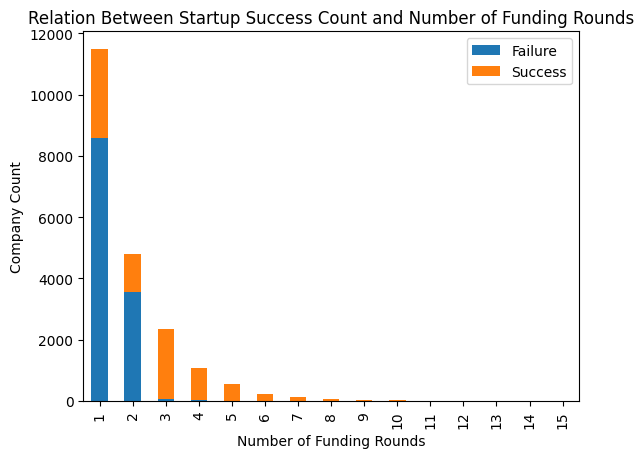

In [61]:
funding_success_counts.plot(kind='bar', stacked=True)
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Company Count')
plt.title('Relation Between Startup Success Count and Number of Funding Rounds')
plt.legend(["Failure", "Success"])
plt.show()

Key Takeaways:
- After 3 rounds of funding, the only way for a company to count as a "failure" is for it to have closed. We see that after 3 rounds of funding, it is very rare for a company to close, and will most likely be successful.

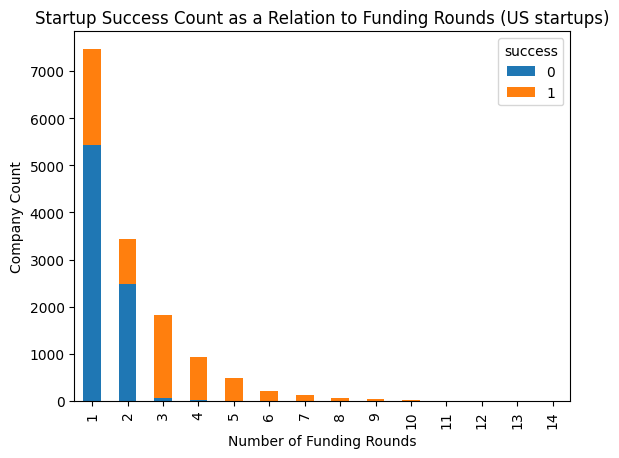

In [62]:
usaFunding = eda1[eda1.country_code == 'USA']
funding = eda1.groupby('funding_rounds')['success'].mean().reset_index(name = "success")
funding_success_counts = usaFunding.pivot_table(index='funding_rounds', columns='success', aggfunc='size', fill_value=0)
funding_success_counts.plot(kind='bar', stacked=True)
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Company Count')
plt.title('Startup Success Count as a Relation to Funding Rounds (US startups)')
plt.show()

## EDA 2: Visualizing startup outcome by country.




Through this analysis, we hope to find a relationship between the success rate of startups in certain countries, and how socioeconomic and political environments affect this rate.

<ipython-input-63-0cb427d5412d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda2.drop_duplicates(inplace=True)
<ipython-input-63-0cb427d5412d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda2.dropna(subset = 'country_code', inplace = True)


Text(0.5, 0, 'Success Rate')

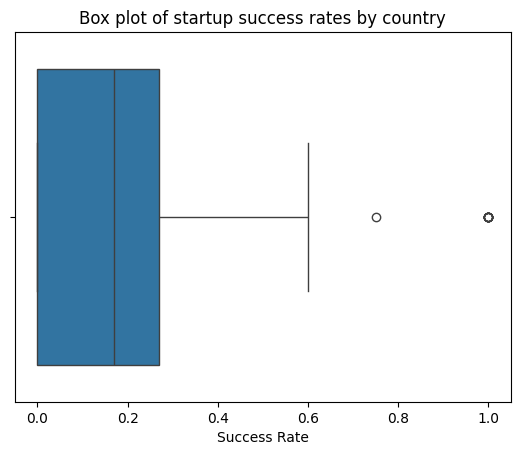

In [63]:
startup_funding_df = startup_funding_df.copy()

eda2 = startup_funding_df[['company_id', 'status', 'success', 'country_code']]
eda2.drop_duplicates(inplace=True)
eda2.dropna(subset = 'country_code', inplace = True)
eda2 = eda2[eda2['country_code'] != ""]
eda2.replace(to_replace = "ipo", value = "acquired", inplace = True)
eda2.replace(to_replace = "acquired", value = "successful", inplace = True)
countries = eda2.groupby('country_code')['success'].mean().reset_index(name = "success")
countries
sns.boxplot(x=countries["success"]).set_title('Box plot of startup success rates by country')
plt.xlabel("Success Rate")


In [64]:
countries = eda2.groupby('country_code')['success'].value_counts()
success_counts = eda2.pivot_table(index='country_code', columns='success', aggfunc='size', fill_value=0)

We see that in our data, we have a lot of countries. A lot of them only have minimal ammounts of startups. In order to have a good visualization, we choose the top 20 countries with the most startups, and normalize the results to get the rates that startups succeed and fail in these countries. Additionally, we normalize success and failure values in order to get the relative rates of success in each country.

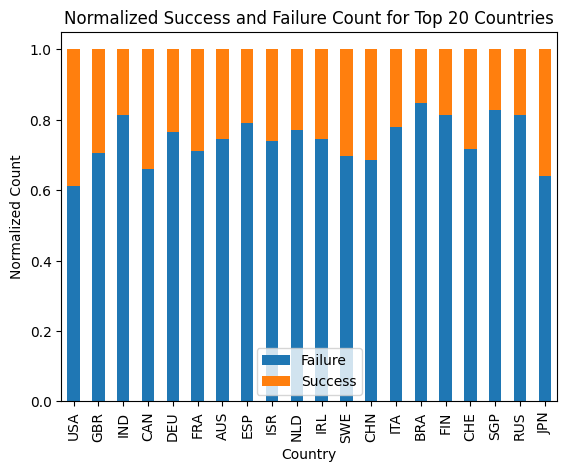

In [65]:
total_counts = success_counts.sum(axis=1)

top_20_countries = total_counts.nlargest(20).index
top_20_success_counts = success_counts.loc[top_20_countries]

normalized_counts = top_20_success_counts.div(top_20_success_counts.sum(axis=1), axis=0)

normalized_counts.plot(kind='bar', stacked=True)

plt.xlabel('Country')
plt.ylabel('Normalized Count')
plt.title('Normalized Success and Failure Count for Top 20 Countries')
plt.legend(["Failure", "Success"])
plt.show()


Key Takeaways:


## EDA 3: Visualizing startup success by category code.



In [66]:
eda3 = startup_funding_df[['company_id', 'status', 'success', 'category_code']]
eda3.drop_duplicates(inplace=True)
eda3.dropna(subset = 'category_code', inplace = True)
eda3.replace(to_replace = "ipo", value = "acquired", inplace = True)
eda3.replace(to_replace = "acquired", value = "successful", inplace = True)

<ipython-input-66-72ad100ae20b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda3.drop_duplicates(inplace=True)
<ipython-input-66-72ad100ae20b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda3.dropna(subset = 'category_code', inplace = True)
<ipython-input-66-72ad100ae20b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda3.replace(to_replace = "ipo", value = "acquired", inplace = True)
<ipython-input-66-72ad100ae20b>:5: Set

In [67]:
success_counts = eda3.pivot_table(index='category_code', columns='success', aggfunc='size', fill_value=0)


In [68]:
total_counts = success_counts.sum(axis=1)
total_counts_filtered = total_counts[total_counts >= 500]
success_counts = success_counts.loc[total_counts_filtered.index]
sorted_indices = (success_counts[0] + success_counts[1]).sort_values().index
success_counts = success_counts.loc[sorted_indices, :]
success_counts

success,0,1
category_code,,
travel,417,120
legal,302,252
medical,288,269
analytics,624,228
finance,601,254
security,494,361
health,593,274
social,861,104
cleantech,684,474


"Other" is not a particularly helpful category, so we will drop it.

In [69]:
success_counts = success_counts.drop(index = "other")

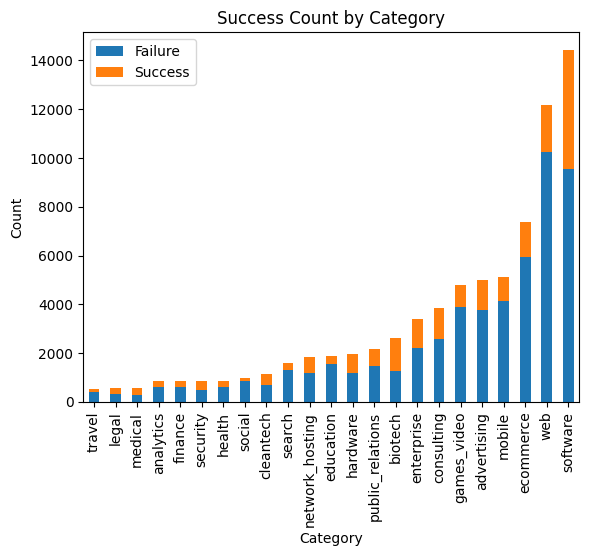

In [70]:
success_counts.plot(kind='bar', stacked=True)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Success Count by Category')
plt.legend(["Failure", "Success"])
plt.show()

Key Takeaways:
- The most frequent startups are those that are tech related, specifically web and software. Despite being quite similar, web has a much lower success rate than software.

##EDA 4: Success Rate and Degree Ratio

In [71]:
eda4 = startup_merge_df[['company_id', 'success', 'degree_ratio']]
eda4.drop_duplicates(inplace=True)
eda4 = eda4.loc[eda4['degree_ratio'] != 0]
eda4.dropna(subset = 'degree_ratio', inplace = True)
eda4fail = eda4.loc[eda4['success'] == 0]
eda4success = eda4.loc[eda4['success'] == 1]

<ipython-input-71-625ccc2325c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda4.drop_duplicates(inplace=True)
<ipython-input-71-625ccc2325c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda4.dropna(subset = 'degree_ratio', inplace = True)


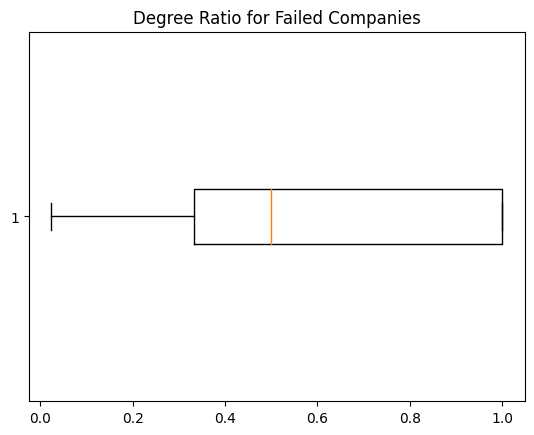

In [72]:
plt.boxplot(eda4fail['degree_ratio'], vert=False)
plt.title('Degree Ratio for Failed Companies')
plt.show()

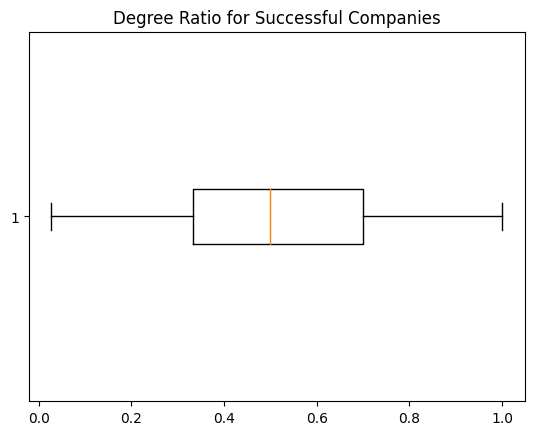

In [73]:
plt.boxplot(eda4success['degree_ratio'], vert=False)
plt.title('Degree Ratio for Successful Companies')
plt.show()

Key Takeaways:

- It seems that degree ratio does not have a large effect on success.
- Failed companies appear to have a larger degree ratio on average. This may be affected by failed companies (especially since they would have less funding rounds) to have less documentation on who is involved with the company.


# Section 3: Feature Engineering



## 3.1: Leaving only important numerical values.

Logically, the only important numerical values in our funding aggregated arrays are the most recent rounds of funding for our modeling data. As this is the round most indicative of the company's progression.     


In [74]:
startup_funding_trimmed_df = startup_funding_df.copy()

In [75]:
startup_funding_trimmed_df['raised_amount_usd'] = startup_funding_trimmed_df['raised_amount_usd'].apply(lambda x: [0] if not x else x)


In [76]:
startup_funding_trimmed_df['important_funding_amount'] = startup_funding_trimmed_df['raised_amount_usd'].apply(max)
startup_funding_trimmed_df['important_funding_round'] = startup_funding_trimmed_df.apply(lambda x: x['funding_round_type'][x['raised_amount_usd'].index(max(x['raised_amount_usd']))] if max(x['raised_amount_usd']) > 0 else 'None', axis=1)
startup_funding_trimmed_df['important_funding_year'] = startup_funding_trimmed_df.apply(lambda x: x['year'][x['raised_amount_usd'].index(max(x['raised_amount_usd']))] if max(x['raised_amount_usd']) > 0 else 'None', axis=1)
startup_funding_trimmed_df['important_funding_code'] = startup_funding_trimmed_df.apply(lambda x: x['funding_round_code'][x['raised_amount_usd'].index(max(x['raised_amount_usd']))] if max(x['raised_amount_usd']) > 0 else 'None', axis=1)
startup_funding_trimmed_df = startup_funding_trimmed_df.drop(columns=['funded_at', 'funding_round_type', 'funding_round_code', 'raised_amount_usd', 'year'])
startup_funding_trimmed_df['important_funding_year'] = pd.to_numeric(startup_funding_trimmed_df['important_funding_year'], errors='coerce')
median_funding_year = startup_funding_trimmed_df['important_funding_year'].median()
startup_funding_trimmed_df['important_funding_round'] = startup_funding_trimmed_df['important_funding_round'].apply(lambda x: x if x != 'None' else "no_funds")
startup_funding_trimmed_df['important_funding_code'] = startup_funding_trimmed_df['important_funding_code'].apply(lambda x: x if x != 'None' else "no_funds")
startup_funding_trimmed_df['important_funding_year'] = startup_funding_trimmed_df['important_funding_year'].fillna(median_funding_year)



In [77]:
startup_funding_trimmed_df

,company_id,name,category_code,status,founded_at,tag_list,country_code,state_code,funding_rounds,funding_total_usd,relationships,founding_year,success,important_funding_amount,important_funding_round,important_funding_year,important_funding_code
0,c:1,Wetpaint,web,operating,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,3,39750000.0,17,2005,1,25000000.0,series-c+,2008.0,c
1,c:10000,MYWEBBO,network_hosting,operating,2008-07-26,"[social-network, new, website, web, friend...",,,0,0.0,0,2008,0,0.0,no_funds,2011.0,no_funds
2,c:10001,THE Movie Streamer,games_video,operating,2008-07-26,"[watch, full-length, moives, online, for, ...",,,0,0.0,0,2008,0,0.0,no_funds,2011.0,no_funds
3,c:10002,Synergie Media,advertising,operating,2007-06-27,"[social-media, web-design, web-development, ...",MAR,,0,0.0,2,2007,0,0.0,no_funds,2011.0,no_funds
4,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,"[cleantech, alternative-energy, biogas, car...",IND,,0,0.0,0,2008,0,0.0,no_funds,2011.0,no_funds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,c:99940,Webgility,ecommerce,operating,2007-01-01,"[ecommerce, quickbooks-sync, intuit-gold-par...",USA,CA,0,0.0,5,2007,0,0.0,no_funds,2011.0,no_funds
91222,c:9995,FohBoh,public_relations,operating,2007-11-01,"[restaurant-industry-social-network, restaura...",USA,CA,1,750000.0,14,2007,0,750000.0,angel,2008.0,angel
91223,c:9996,CSC,consulting,operating,1959-01-01,[],USA,VA,0,0.0,44,1959,1,0.0,no_funds,2011.0,no_funds
91224,c:9997,Top-candidate,search,operating,2008-07-01,"[resumes, resume-database, resume-search, r...",USA,CA,0,0.0,1,2008,0,0.0,no_funds,2011.0,no_funds


In [78]:
intermediate_df = startup_funding_trimmed_df.copy()
feature_df = intermediate_df.merge(startup_merge_df, on='company_id', how='inner')
columns_to_drop = [col for col in feature_df.columns if col.endswith('_y')]
feature_df = feature_df.drop(columns=columns_to_drop)
rename_dict = {col: col.rstrip('_x') for col in feature_df.columns if col.endswith('_x')}
feature_df.rename(columns=rename_dict, inplace=True)

In [79]:
feature_df = feature_df.drop(['name', 'status', 'funding_rounds', 'person_object_id', 'first_name', 'last_name', 'relationship_object_id', "subject", "institution", "graduated_at"], axis=1)
feature_df = feature_df[feature_df['country_code'].notna() & feature_df['degree_type'].notna()]
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265411 entries, 0 to 297291
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   company_id                265411 non-null  object        
 1   category_code             265411 non-null  object        
 2   founded_at                265411 non-null  datetime64[ns]
 3   tag_list                  265411 non-null  object        
 4   country_code              265411 non-null  object        
 5   state_code                265411 non-null  object        
 6   funding_total_usd         265411 non-null  float64       
 7   relationships             265411 non-null  int64         
 8   founding_year             265411 non-null  int64         
 9   success                   265411 non-null  int64         
 10  important_funding_amount  265411 non-null  float64       
 11  important_funding_round   265411 non-null  object        
 12  importa

In [80]:
feature_df['milestone_count'] = feature_df['milestone_count'].fillna(0)
feature_df

,company_id,category_code,founded_at,tag_list,country_code,state_code,funding_total_usd,relationships,founding_year,success,...,important_funding_code,funded_at,funding_round_type,funding_round_code,raised_amount_usd,year,is_past,degree_type,degree_ratio,milestone_count
0,c:1,web,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,39750000.0,17,2005,1,...,c,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",0.0,BS,0.75,2.0
1,c:1,web,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,39750000.0,17,2005,1,...,c,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",0.0,BS,0.75,2.0
2,c:1,web,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,39750000.0,17,2005,1,...,c,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",1.0,unknown,0.75,2.0
3,c:1,web,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,39750000.0,17,2005,1,...,c,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",0.0,unknown,0.75,2.0
4,c:1,web,2005-10-17,"[wiki, seattle, elowitz, media-industry, m...",USA,WA,39750000.0,17,2005,1,...,c,"[2005-10-01, 2007-01-01, 2008-05-19]","[series-a, series-b, series-c+]","[a, b, c]","[5250000.0, 9500000.0, 25000000.0]","[2005, 2007, 2008]",1.0,Graduate Certificate,0.75,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297287,c:9996,consulting,1959-01-01,[],USA,VA,0.0,44,1959,1,...,no_funds,[],[],[],[],[],1.0,unknown,0.60,1.0
297288,c:9996,consulting,1959-01-01,[],USA,VA,0.0,44,1959,1,...,no_funds,[],[],[],[],[],1.0,unknown,0.60,1.0
297289,c:9997,search,2008-07-01,"[resumes, resume-database, resume-search, r...",USA,CA,0.0,1,2008,0,...,no_funds,[],[],[],[],[],0.0,unknown,0.00,0.0
297290,c:9998,ecommerce,2007-09-01,"[techcrunch50, tc50, fashion, social-networ...",USA,CA,475000.0,1,2007,0,...,seed,[2008-06-01],[angel],[seed],[475000.0],[2008],0.0,MS,1.00,0.0


In [81]:
feature_df = feature_df.groupby('company_id')
feature_df

In [82]:
feature_df = feature_df.agg({
    'category_code': 'first',
    'founding_year': 'first',
    'country_code': 'first',
    'state_code': 'first',
    'funding_total_usd': 'first',
    'relationships': 'first',
    #'degree_type': list,
    'is_past': 'sum',
    'founding_year': 'first',
    'success': 'first',
    'important_funding_amount': 'first',
    'important_funding_round': 'first',
    'important_funding_year': 'first',
    'important_funding_code': 'first',
    'milestone_count': 'first',
}).reset_index()

In [83]:
feature_df.drop(columns=[])
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59266 entries, 0 to 59265
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_id                59266 non-null  object 
 1   category_code             59266 non-null  object 
 2   founding_year             59266 non-null  int64  
 3   country_code              59266 non-null  object 
 4   state_code                59266 non-null  object 
 5   funding_total_usd         59266 non-null  float64
 6   relationships             59266 non-null  int64  
 7   is_past                   59266 non-null  float64
 8   success                   59266 non-null  int64  
 9   important_funding_amount  59266 non-null  float64
 10  important_funding_round   59266 non-null  object 
 11  important_funding_year    59266 non-null  float64
 12  important_funding_code    59266 non-null  object 
 13  milestone_count           59266 non-null  float64
dtypes: flo

In [84]:
feature_df

,company_id,category_code,founding_year,country_code,state_code,funding_total_usd,relationships,is_past,success,important_funding_amount,important_funding_round,important_funding_year,important_funding_code,milestone_count
0,c:1,web,2005,USA,WA,39750000.0,17,13.0,1,25000000.0,series-c+,2008.0,c,2.0
1,c:10002,advertising,2007,MAR,,0.0,2,0.0,0,0.0,no_funds,2011.0,no_funds,0.0
2,c:100062,enterprise,2011,,,0.0,2,0.0,0,0.0,no_funds,2011.0,no_funds,0.0
3,c:10009,advertising,2008,USA,NM,0.0,2,0.0,0,0.0,no_funds,2011.0,no_funds,1.0
4,c:1001,web,2007,USA,CA,5000000.0,14,14.0,1,5000000.0,series-a,2008.0,a,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59261,c:99940,ecommerce,2007,USA,CA,0.0,5,1.0,0,0.0,no_funds,2011.0,no_funds,5.0
59262,c:9995,public_relations,2007,USA,CA,750000.0,14,10.0,0,750000.0,angel,2008.0,angel,0.0
59263,c:9996,consulting,1959,USA,VA,0.0,44,53.0,1,0.0,no_funds,2011.0,no_funds,1.0
59264,c:9997,search,2008,USA,CA,0.0,1,0.0,0,0.0,no_funds,2011.0,no_funds,0.0


# Correlation of Features

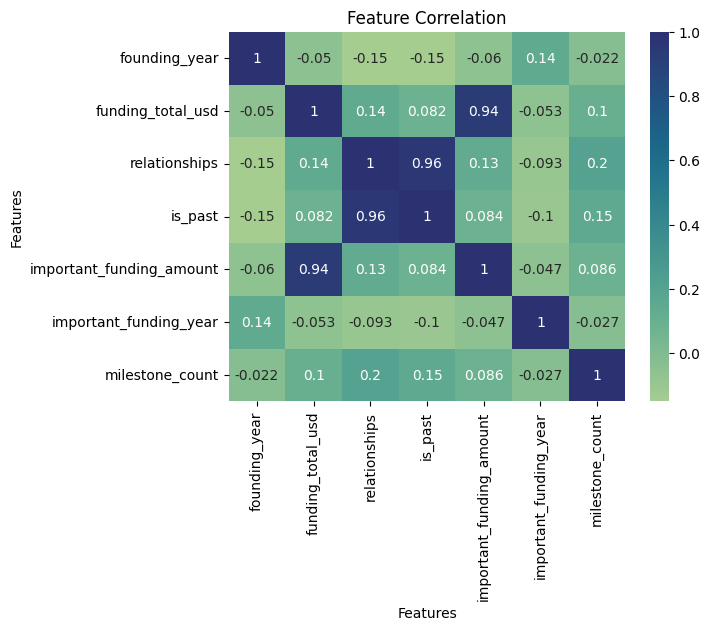

In [85]:
corr_df = feature_df[['founding_year', 'funding_total_usd', 'relationships', 'is_past', 'important_funding_amount', 'important_funding_year', 'milestone_count', ]]
dataplot = sns.heatmap(corr_df.corr(), cmap = 'crest', annot = True)
plt.title("Feature Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

Here we can see that is_past and important_funding_amount are highly correlated to relationships and funding_total_usd. This is an expected result, but through verification of this in the correlation matrix, we can feel confident removing both the is_past and important_funding_amount columns.

In [86]:
# Removing is_past and important_funding_amount column:
feature_df = feature_df.drop(['is_past', 'important_funding_amount'], axis=1)

# Section 4: Modeling


## 4.01 Categories of columns.

In [87]:
categorical_cols = ['category_code', 'country_code', 'state_code', 'important_funding_round', 'important_funding_code']
numeric_cols = ['founding_year', 'funding_total_usd', 'relationships', 'important_funding_year', 'milestone_count']

## 4.1 Baseline Logistic Regression Model for Successes.

In [ ]:
logreg_df = feature_df.copy()
logreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59266 entries, 0 to 59265
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_id               59266 non-null  object 
 1   category_code            59266 non-null  object 
 2   founding_year            59266 non-null  int64  
 3   country_code             59266 non-null  object 
 4   state_code               59266 non-null  object 
 5   funding_total_usd        59266 non-null  float64
 6   relationships            59266 non-null  int64  
 7   success                  59266 non-null  int64  
 8   important_funding_round  59266 non-null  object 
 9   important_funding_year   59266 non-null  float64
 10  important_funding_code   59266 non-null  object 
 11  milestone_count          59266 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 5.4+ MB


In [ ]:
logreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59266 entries, 0 to 59265
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_id               59266 non-null  object 
 1   category_code            59266 non-null  object 
 2   founding_year            59266 non-null  int64  
 3   country_code             59266 non-null  object 
 4   state_code               59266 non-null  object 
 5   funding_total_usd        59266 non-null  float64
 6   relationships            59266 non-null  int64  
 7   success                  59266 non-null  int64  
 8   important_funding_round  59266 non-null  object 
 9   important_funding_year   59266 non-null  float64
 10  important_funding_code   59266 non-null  object 
 11  milestone_count          59266 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 5.4+ MB


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
            ('scaler', StandardScaler())  # Scale the numeric features
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [ ]:
X = logreg_df.drop(['company_id', 'success'], axis=1)  # drop non-features and target
y = logreg_df['success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
param_grid = {
    'penalty': [None, 'l1', 'l2'],
}

In [ ]:
max_test_acc, best_params = 0, None

for params in list(ParameterGrid(param_grid)):
    # Choose solver based on penalty
    solver = 'liblinear' if params['penalty'] == 'l1' else 'lbfgs'
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver=solver, random_state=42, max_iter=10000, **params))
    ])
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print accuracies and report
    print("Train accuracy for Logistic Regression: ", train_acc)
    print("Test accuracy for Logistic Regression:  ", test_acc)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    curr_test_acc = model.score(X_test, y_test)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for Logistic Regression: ", best_params)


Train accuracy for Logistic Regression:  0.9185990454611194
Test accuracy for Logistic Regression:   0.9153543307086615
Accuracy: 0.9153543307086615
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12617
           1       0.90      0.80      0.85      5163

    accuracy                           0.92     17780
   macro avg       0.91      0.88      0.89     17780
weighted avg       0.91      0.92      0.91     17780

Train accuracy for Logistic Regression:  0.918213373186135
Test accuracy for Logistic Regression:   0.9162542182227221
Accuracy: 0.9162542182227221
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12617
           1       0.90      0.80      0.85      5163

    accuracy                           0.92     17780
   macro avg       0.91      0.88      0.89     17780
weighted avg       0.92      0.92      0.91     17780

Tra

In [ ]:
solver = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver=solver, random_state=42, max_iter=10000, **best_params))
])
final_model.fit(X_train, y_train)

train_acc = final_model.score(X_train, y_train)
test_acc = final_model.score(X_test, y_test)
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print accuracies and report
print("Train accuracy for Logistic Regression: ", train_acc)
print("Test accuracy for Logistic Regression:  ", test_acc)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Train accuracy for Logistic Regression:  0.918213373186135
Test accuracy for Logistic Regression:   0.9162542182227221
Accuracy: 0.9162542182227221
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12617
           1       0.90      0.80      0.85      5163

    accuracy                           0.92     17780
   macro avg       0.91      0.88      0.89     17780
weighted avg       0.92      0.92      0.91     17780



# **4.2 Decision Tree**

In [ ]:
decision_tree_df = feature_df.copy()
decision_tree_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59266 entries, 0 to 59265
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_id               59266 non-null  object 
 1   category_code            59266 non-null  object 
 2   founding_year            59266 non-null  int64  
 3   country_code             59266 non-null  object 
 4   state_code               59266 non-null  object 
 5   funding_total_usd        59266 non-null  float64
 6   relationships            59266 non-null  int64  
 7   success                  59266 non-null  int64  
 8   important_funding_round  59266 non-null  object 
 9   important_funding_year   59266 non-null  float64
 10  important_funding_code   59266 non-null  object 
 11  milestone_count          59266 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 5.4+ MB


In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

max_depths = [10, 20, 30, None]
min_samples_splits = [2, 8, 32]
min_samples_leafs = [1, 4, 16]
max_features_options = ['sqrt', 'log2', None]
criteria = ['gini', 'entropy']

best_score = 0
best_params = {}



X = decision_tree_df.drop('success', axis=1)
y = decision_tree_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leafs:
            for max_features in max_features_options:
                for criterion in criteria:
                    # Set up the decision tree classifier with current parameters
                    model = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            criterion=criterion,
                            random_state=42))
                    ])

                    # Fit the model
                    model.fit(X_train, y_train)

                    # Predict on validation set
                    y_val_pred = model.predict(X_test)

                    # Calculate accuracy
                    current_score = accuracy_score(y_test, y_val_pred)

                    # Update best score and parameters if current score is better
                    if current_score > best_score:
                        best_score = current_score
                        best_params = {
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features,
                            'criterion': criterion
                        }

print("Best Parameters Found:")
print(best_params)
print(f"Best Accuracy: {best_score}")

Best Parameters Found:
{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': None, 'criterion': 'gini'}
Best Accuracy: 0.9306524184476941


In [ ]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        criterion=best_params['criterion'],
        random_state=42))
])

final_model.fit(X_train, y_train)
# Predict on the training set
y_train_pred = model.predict(X_train)

# Predict on the test set
y_test_pred = model.predict(X_test)


In [ ]:
# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Data:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.941908113580485
Test Accuracy: 0.9286276715410574
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     12617
           1       0.92      0.82      0.87      5163

    accuracy                           0.93     17780
   macro avg       0.93      0.90      0.91     17780
weighted avg       0.93      0.93      0.93     17780



log reg -> tree -> random forest -> nn


tree based models are susceptible to overfitting #potentially they memorize train set v well -> neural networks have slightly better overfitting properties.

# **4.4 Neural Network**

In [88]:
neuralNetwork_df = feature_df.copy()
neuralNetwork_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59266 entries, 0 to 59265
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_id               59266 non-null  object 
 1   category_code            59266 non-null  object 
 2   founding_year            59266 non-null  int64  
 3   country_code             59266 non-null  object 
 4   state_code               59266 non-null  object 
 5   funding_total_usd        59266 non-null  float64
 6   relationships            59266 non-null  int64  
 7   success                  59266 non-null  int64  
 8   important_funding_round  59266 non-null  object 
 9   important_funding_year   59266 non-null  float64
 10  important_funding_code   59266 non-null  object 
 11  milestone_count          59266 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 5.4+ MB


In [89]:
# Create a preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ],
    sparse_threshold=0)  # This forces the output to be a dense array

# Assume neuralNetwork_df is your DataFrame
X = neuralNetwork_df.drop(['company_id', 'success'], axis=1)
y = neuralNetwork_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert the dense numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_test = torch.tensor(X_test.astype(np.float32))
y_test = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)


In [90]:
num_layers_options = [1, 2, 4]
layer_sizes_options = [16, 32, 128]
learning_rates = [0.001, 0.0001]

In [91]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.ModuleList()
        # this layer will always be of size input_dim
        self.layers.append(nn.Linear(input_dim, layer_size))

        # Add (layer_size-1) hidden layers
        for _ in range(1, num_layers):
            self.layers.append(nn.Linear(layer_size, layer_size))

        # last layer has to give output so point it to 1
        self.layers.append(nn.Linear(layer_size, 1))

    def forward(self, x):
        # Pass data through hidden layers, applying ReLU activation to each except the last
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
        # Apply sigmoid activation to the output of the last layer
        x = torch.sigmoid(self.layers[-1](x))
        return x



In [92]:
def train_evaluate_model(num_layers, layer_size, learning_rate, final_model):
    model = BinaryClassifier(input_dim=X_train.shape[1], num_layers=num_layers, layer_size=layer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCELoss()
    epoch_amount = 1000
    if final_model:
      epoch_amount = 10000
      learning_rate = learning_rate

    print(epoch_amount)
    for epoch in range(epoch_amount):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).float().mean()

    if final_model:
        y_true = y_test.numpy()
        y_pred = predicted.numpy()
        print("Final model evaluation:")
        print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))
        print(f"Accuracy: {accuracy:.4f}")


    return accuracy

In [93]:
best_accuracy = 0
best_settings = {}

for num_layers in num_layers_options:
    for layer_size in layer_sizes_options:
        for learning_rate in learning_rates:
            accuracy = train_evaluate_model(num_layers, layer_size, learning_rate, False)
            print(f'Results for: {num_layers} layer(s), {layer_size} layer size, {learning_rate} alpha: Accuracy {accuracy:.4f}')

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_settings = {'num_layers': num_layers, 'layer_size': layer_size, 'learning_rate': learning_rate}

print("Best settings:", best_settings)
print("Best accuracy:", best_accuracy)

1000
Results for: 1 layer(s), 16 layer size, 0.001 alpha: Accuracy 0.9199
1000
Results for: 1 layer(s), 16 layer size, 0.0001 alpha: Accuracy 0.8051
1000
Results for: 1 layer(s), 32 layer size, 0.001 alpha: Accuracy 0.9213
1000
Results for: 1 layer(s), 32 layer size, 0.0001 alpha: Accuracy 0.8287
1000
Results for: 1 layer(s), 128 layer size, 0.001 alpha: Accuracy 0.9183
1000
Results for: 1 layer(s), 128 layer size, 0.0001 alpha: Accuracy 0.8794
1000
Results for: 2 layer(s), 16 layer size, 0.001 alpha: Accuracy 0.9230
1000
Results for: 2 layer(s), 16 layer size, 0.0001 alpha: Accuracy 0.8333
1000
Results for: 2 layer(s), 32 layer size, 0.001 alpha: Accuracy 0.9189
1000
Results for: 2 layer(s), 32 layer size, 0.0001 alpha: Accuracy 0.8892
1000
Results for: 2 layer(s), 128 layer size, 0.001 alpha: Accuracy 0.9080
1000
Results for: 2 layer(s), 128 layer size, 0.0001 alpha: Accuracy 0.9221
1000
Results for: 4 layer(s), 16 layer size, 0.001 alpha: Accuracy 0.9231
1000
Results for: 4 layer(s)

In [94]:
#X_train.shape[1] = 263
train_evaluate_model(best_settings['num_layers'], best_settings['layer_size'], best_settings['learning_rate'], True)

10000
Final model evaluation:
              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94      8395
     Class 1       0.89      0.80      0.84      3459

    accuracy                           0.91     11854
   macro avg       0.90      0.88      0.89     11854
weighted avg       0.91      0.91      0.91     11854

Accuracy: 0.9107


tensor(0.9107)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

AttributeError: 'Pipeline' object has no attribute 'parameters'